In [23]:
import pandas as pd
import re
#!pip install nltk
import nltk
import numpy as np 
import os
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # download tokenizer - to split text strings into words
from nltk.stem import PorterStemmer

from wordcloud import WordCloud
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /home/oliver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/oliver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
cwd = os.getcwd()
df = pd.read_csv(cwd + '/scraped_hotel_data.csv')
df.head()

,url,hotel_name,description,room_type,city,start_date,end_date,rating,price
0,https://www.booking.com/hotel/es/margot-house....,Hotel Margot House Barcelona,El Hotel Margot House Barcelona está ubicado e...,Habitación Doble Estándar Interior,Barcelona,2025-06-03,2025-06-09,8.8,€ 2.509
1,https://www.booking.com/hotel/es/flor-parks.es...,Flor Parks,"El Flor Parks, que ofrece terraza en la azotea...",Habitación Doble (1-2 adultos),Barcelona,2025-06-03,2025-06-09,8.5,€ 2.113
2,https://www.booking.com/hotel/es/four-points-b...,Four Points by Sheraton Barcelona Airport,Four Points by Sheraton Barcelona Airport está...,Habitación con cama extragrande.,Barcelona,2025-06-03,2025-06-09,8.7,€ 541
3,https://www.booking.com/hotel/es/hotel-viladom...,Hotel Viladomat,El Hotel Viladomat goza de una ubicación idóne...,Habitación Doble Básica - 1 o 2 camas,Barcelona,2025-06-03,2025-06-09,7.6,€ 1.786
4,https://www.booking.com/hotel/es/catalonia-bar...,Catalonia Barcelona 505,El Catalonia Barcelona 505 se encuentra en la ...,Habitación Doble - 1 o 2 camas,Barcelona,2025-06-03,2025-06-09,8.5,€ 1.455


# 0. Basic cleaning

In [25]:
# renaming columns for simplicity
df.columns = ['url', 'hotel', 'description', 'room_type', 'city', 'start_date', 'end_date',
       'rating', 'price']
df.dtypes

url             object
hotel           object
description     object
room_type       object
city            object
start_date      object
end_date        object
rating         float64
price           object
dtype: object

In [26]:
# ADDING BOOLEAN COLUMNS FOR BARCELONA AND FOR PRIMAVERA SOUND DATES

df['bcn_bool'] = np.where(df.city == 'Barcelona', 1, 0)
df['primavera_sound_bool'] = np.where(df.start_date == '2025-06-03', 1, 0)

In [27]:
# TURNING PRICE COLUMN INTO FLOATS
df.price = df.price.str.replace('€', '', regex=False).str.replace('.', '', regex=False).str.strip()
df.price = df.price.astype(float)

In [28]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
df.rating = df.groupby('city')['rating'].transform(lambda x: mean_imputer.fit_transform(x.values.reshape(-1, 1)).flatten())
df.price = mean_imputer.fit_transform(df[['price']]).flatten()

mode_imputer = SimpleImputer(strategy='most_frequent')
df['room_type'] = mode_imputer.fit_transform(df[['room_type']]).ravel()

In [29]:
df.head()

,url,hotel,description,room_type,city,start_date,end_date,rating,price,bcn_bool,primavera_sound_bool
0,https://www.booking.com/hotel/es/margot-house....,Hotel Margot House Barcelona,El Hotel Margot House Barcelona está ubicado e...,Habitación Doble Estándar Interior,Barcelona,2025-06-03,2025-06-09,8.8,2509.0,1,1
1,https://www.booking.com/hotel/es/flor-parks.es...,Flor Parks,"El Flor Parks, que ofrece terraza en la azotea...",Habitación Doble (1-2 adultos),Barcelona,2025-06-03,2025-06-09,8.5,2113.0,1,1
2,https://www.booking.com/hotel/es/four-points-b...,Four Points by Sheraton Barcelona Airport,Four Points by Sheraton Barcelona Airport está...,Habitación con cama extragrande.,Barcelona,2025-06-03,2025-06-09,8.7,541.0,1,1
3,https://www.booking.com/hotel/es/hotel-viladom...,Hotel Viladomat,El Hotel Viladomat goza de una ubicación idóne...,Habitación Doble Básica - 1 o 2 camas,Barcelona,2025-06-03,2025-06-09,7.6,1786.0,1,1
4,https://www.booking.com/hotel/es/catalonia-bar...,Catalonia Barcelona 505,El Catalonia Barcelona 505 se encuentra en la ...,Habitación Doble - 1 o 2 camas,Barcelona,2025-06-03,2025-06-09,8.5,1455.0,1,1


# 1. Basic Text Analysis
To do:
* Drop stopwords from descriptions
* Stemming in descriptions

## 1.1. Stopwords

In [30]:
# STOPWORDS

stop_words = set(stopwords.words('spanish'))

custom_stopwords = set(stop_words)
#custom_stopwords.update([list])  # add words??
additional_stopwords = [
    'de', 'del', 'en', 'la', 'el', 'los', 'las', 'y', 'al', 'para', 'por',
    'hotel', 'establecimiento', 'habitaciones', 'se', 'encuentra', 'además', 'madrid', 'barcelona',
    'alojamiento', 'apartamento'
]

# Update the custom stopword set with additional stopwords
custom_stopwords.update(additional_stopwords)
# Removing words
remove_list = ['ante', 'desde', 'sin']
for word in remove_list:
    custom_stopwords.discard(word)

In [31]:
# function to remove stopwords
def clean_text(text, stopwords):
    # 1. tokenize the text
    words = re.findall(r'\b\w+\b', text.lower())
    # 2. remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words) 

# Apply the clean_text function to the 'text' column
df['clean_description'] = df['description'].apply(lambda x: clean_text(x, custom_stopwords))

# Display the cleaned DataFrame
df[['description', 'clean_description']]

,description,clean_description
0,El Hotel Margot House Barcelona está ubicado e...,margot house ubicado situado frente casa batll...
1,"El Flor Parks, que ofrece terraza en la azotea...",flor parks ofrece terraza azotea wifi gratuita...
2,Four Points by Sheraton Barcelona Airport está...,four points by sheraton airport 16 km fuente m...
3,El Hotel Viladomat goza de una ubicación idóne...,viladomat goza ubicación idónea menos 10 minut...
4,El Catalonia Barcelona 505 se encuentra en la ...,catalonia 505 zona sant gervasi dispone piscin...
...,...,...
3988,Exclusivo Apartamento en Sol está en una zona ...,exclusivo sol zona céntrica ofrece vistas ciud...
3989,Malasaña VII calle San Mateo 3BR 3BH ofrece wi...,malasaña vii calle san mateo 3br 3bh ofrece wi...
3990,Sunny Apartment 6pax en Plaza del Carmen-Preci...,sunny apartment 6pax plaza carmen preciados e2...
3991,CavaBajaSuites 2 se encuentra en el centro de ...,cavabajasuites 2 centro 5 min pie plaza mayor ...


## 1.2. Stemming

In [32]:
ps = PorterStemmer()

# Your preprocess_stem function
def preprocess_stem(text):
    # Tokenize the cleaned text
    tokens = word_tokenize(text)
    
    # Stem each token
    stemmed_tokens = [ps.stem(token) for token in tokens]
    
    # Join the stemmed tokens into a single string
    return " ".join(stemmed_tokens)

# Apply preprocess_stem to the 'clean_description' column
df['stemmed_description'] = df['clean_description'].apply(preprocess_stem)

# Display the original, cleaned, and stemmed descriptions
df[['description', 'clean_description', 'stemmed_description']].head()


,description,clean_description,stemmed_description
0,El Hotel Margot House Barcelona está ubicado e...,margot house ubicado situado frente casa batll...,margot hous ubicado situado frent casa batlló ...
1,"El Flor Parks, que ofrece terraza en la azotea...",flor parks ofrece terraza azotea wifi gratuita...,flor park ofrec terraza azotea wifi gratuita r...
2,Four Points by Sheraton Barcelona Airport está...,four points by sheraton airport 16 km fuente m...,four point by sheraton airport 16 km fuent mág...
3,El Hotel Viladomat goza de una ubicación idóne...,viladomat goza ubicación idónea menos 10 minut...,viladomat goza ubicación idónea meno 10 minuto...
4,El Catalonia Barcelona 505 se encuentra en la ...,catalonia 505 zona sant gervasi dispone piscin...,catalonia 505 zona sant gervasi dispon piscina...


## 1.3. Removing numbers

In [33]:
def preprocess_numbers(text):
    return re.sub(r'\d+', '', text)

df['stopwords_description'] = df['stemmed_description'].apply(preprocess_numbers)

df[['description', 'stopwords_description', 'stemmed_description', 'clean_description']].head(3)

,description,stopwords_description,stemmed_description,clean_description
0,El Hotel Margot House Barcelona está ubicado e...,margot hous ubicado situado frent casa batlló ...,margot hous ubicado situado frent casa batlló ...,margot house ubicado situado frente casa batll...
1,"El Flor Parks, que ofrece terraza en la azotea...",flor park ofrec terraza azotea wifi gratuita r...,flor park ofrec terraza azotea wifi gratuita r...,flor parks ofrece terraza azotea wifi gratuita...
2,Four Points by Sheraton Barcelona Airport está...,four point by sheraton airport km fuent mágic...,four point by sheraton airport 16 km fuent mág...,four points by sheraton airport 16 km fuente m...


# 2. Wordclouds

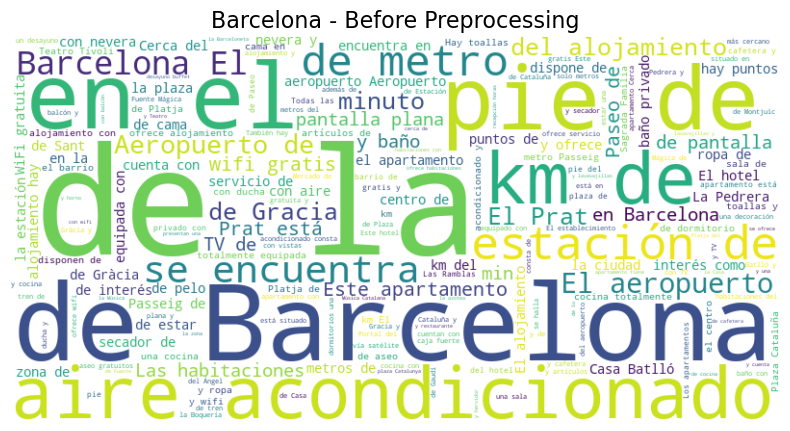

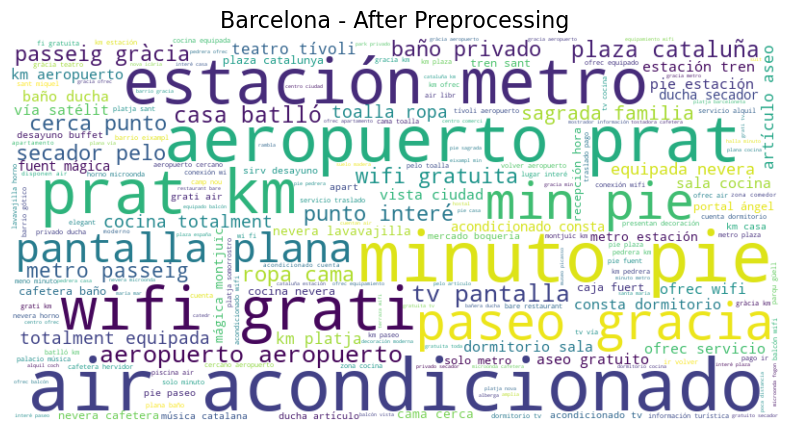

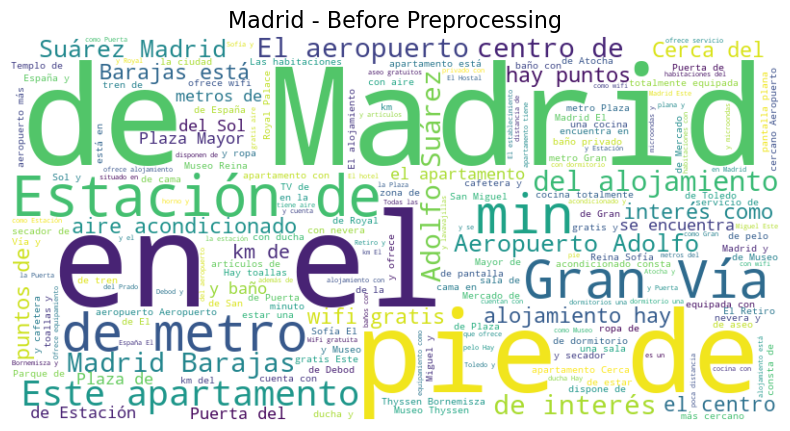

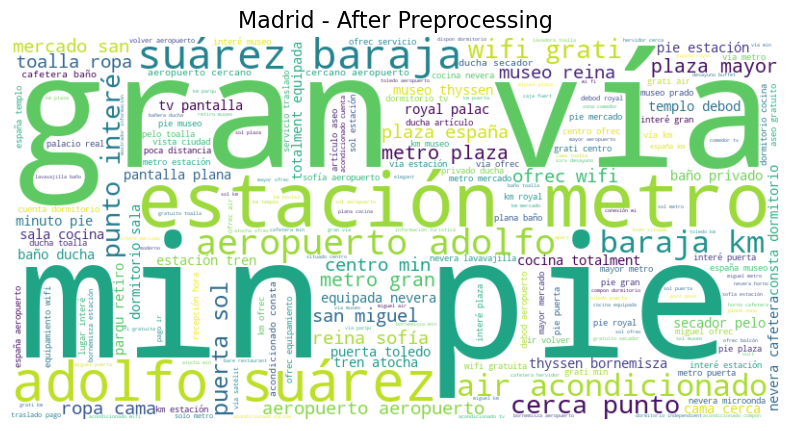

In [34]:
# Combine all descriptions for each city before and after preprocessing
barcelona_text_before = ' '.join(df[df['city'] == 'Barcelona']['description'])
barcelona_text_after = ' '.join(df[df['city'] == 'Barcelona']['stemmed_description'])

madrid_text_before = ' '.join(df[df['city'] == 'Madrid']['description'])
madrid_text_after = ' '.join(df[df['city'] == 'Madrid']['stemmed_description'])

# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Generate word clouds for Barcelona
generate_wordcloud(barcelona_text_before, "Barcelona - Before Preprocessing")
generate_wordcloud(barcelona_text_after, "Barcelona - After Preprocessing")

# Generate word clouds for Madrid
generate_wordcloud(madrid_text_before, "Madrid - Before Preprocessing")
generate_wordcloud(madrid_text_after, "Madrid - After Preprocessing")


### Interpretation

*Non-Processed:*

We can clearly see how common Spanish stopwords such as "de," "la," "y," and "en" dominate the non-preprocessing word clouds, slightly overshadowing meaningful terms.
General hotel-related terms like "habitaciones," "minuto," and "estación" are present but less prominent due to the noise from stopwords.
Proper nouns like "Barcelona" are highlighted, which aligns with the context of the dataset.

*After Processing:*

The removal of stopwords like "de," "la," "y," and "en" makes the word cloud more focused on relevant terms.
Words such as "minuto," "pie," "metro," "pantalla plana," and "aire acondicionado" become dominant, leading to a clearer picture of key features in hotel descriptions.
Specific amenities and location-related words like "wifi gratuita" and "elegante" stand out, which are more useful for analysis.

*General*:

In general, regarding our Event Analysis, these wordclouds do not do a ton for us wrt. the specific research question.(i.e. we cannot see event related terms in the Barcelona wordcloud) However, this makes sense as hotels do not change their descriptions depending on an event. 
However, we can see quite well how pre processing helps and what the main themes of the hotel descriptions are. (i.e. business travel or tourism related terms)

# 3. DiD Regression

## 3.1.a) Difference-in-Differences (DiD) Regression to Analyze Event Effects on Prices

To estimate the effect of an event (e.g., Primavera Sound) on hotel prices, we can use a Difference-in-Differences (DiD) regression with fixed effects. The regression equation is as follows:

$$
\text{price}_{ict} = \beta_0 + \beta_1 (\text{event}_t) + \beta_2 (\text{treated}_c) + \beta_3 (\text{event}_t \times \text{treated}_c) +\mathbf{X}_{ict}\mathbf{w}_{ict}+ \epsilon_{ict}
$$


Where :

Dependent variable:
- price = Price of a hotel in city *c* at time *t* for hotel *i* (dependent variable).

Independent variables:
- $\beta_0$ = The intercept of the regression equation.
- $\beta_1$ = Captures the difference in prices between the event timeframe and non-event timeframe. *event* is a binary variable that equals 1 during the event period (e.g., Primavera Sound) and 0 otherwise.
- $\beta_2$ = Captures the difference in prices between the treated city (Barcelona) and the control city (Madrid). *event* is a binary variable that equals 1 for Barcelona (treated city) and 0 for the control city (e.g., Madrid).
- $\beta_3$ = The interaction term (Difference-in-Differences term), which measures the treatment effect of the event on hotel prices in Barcelona.
- $ \mathbf{X}_{ict} $: Vector of other control variables. See examples below! (e.g., hotel ratings, characteristics) to account for heterogeneity.
- $ \mathbf{w}_{ict} $: Corresponding coefficients of additional control variables.
- $\epsilon_{ict}$: Error term.


indices:

- *i*: hotel
- *t*: timeframe
- *c*: city




### Controls to Include
1. **Hotel Ratings**:  
   Controls for the effect of hotel quality on prices.

2. **Room Type**:
   Prices depend on room type. If this is left out, price differences could be due to different room types between the timeframes rather than the event it selves. Including room types isolates the true impact of the event on hotel prices.


3. **Other Events** :  
   Ensures price changes are not driven by overlapping events.

4. **Text Features**:  
   As described below, ie. sentiment analysis

5. **Seasonality**:
   Indicates whether there is a seasonal pattern for the respective city, influencing the price and availability of hotels
---

### Why is a Second City Necessary?
Including a second city (e.g., Madrid) as a control group is crucial for the Difference-in-Differences methodology:
1. **Counterfactual Analysis**:  
   The control city provides a counterfactual to estimate what would have happened to hotel prices in Barcelona if the event had not occurred.

2. **Parallel Trends Assumption**:  
   The method assumes that, in the absence of the event, the price trends in the treated city (Barcelona) and the control city (Madrid) would have been the same. This helps isolate the causal effect of the event.

3. **Event-Specific Effects**:  
   Without a second city, it's impossible to distinguish between price changes caused by the event and those caused by general economic conditions or demand trends.

---


### Fitting the model

Below we fit the regression model according to the equation above. We include Rating as an example of additional features. This can be extended and other features like described above can be included.
For example, a model including room types which could be very essential for such a price analysis is fitted below.

In [35]:
#add DiD
df['DiD'] = df['bcn_bool'] * df['primavera_sound_bool'] 

In [36]:
import statsmodels.api as sm #for regression

X = df[['primavera_sound_bool', 'bcn_bool', 'DiD', 'rating']]

X = sm.add_constant(X)  # Adds intercept
X = X.apply(pd.to_numeric, errors='coerce')

y = df['price']

regression = sm.OLS(y, X).fit()
print(regression.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     180.6
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          2.19e-142
Time:                        23:49:40   Log-Likelihood:                -34943.
No. Observations:                3993   AIC:                         6.990e+04
Df Residuals:                    3988   BIC:                         6.993e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1244.6495 

### Short Interpretation

We can see how Primavera Sound and being located in Barcelona both have significant positive effects on hotel prices.
The Difference-in-Differences result suggests that the event had an additional positive price impact on hotels in Barcelona relative to Madrid. However, it is strictly speaking not significant, as its p-value is close to but not below the threshold of 5%.
Rating is not significant.
Since R² is quite low, the model doesn’t explain a huge portion of the variance in prices (15.3%).

In [37]:
import statsmodels.api as sm #for regression

#The ratings column has a missing value, so we will fill it with the mean for its city.
from sklearn.impute import SimpleImputer

room_dummies = pd.get_dummies(df['room_type'], prefix='room', drop_first=True).astype(int)
# Concatenate with the original DataFrame
df = pd.concat([df, room_dummies], axis=1)

imputer = SimpleImputer(strategy='mean')
df.rating = df.groupby('city')['rating'].transform(lambda x: imputer.fit_transform(x.values.reshape(-1, 1)).flatten())
X = df[['primavera_sound_bool', 'bcn_bool', 'DiD', 'rating'] + list(room_dummies.columns)]

X = sm.add_constant(X)  # Adds intercept
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

y = df['price']

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     7.471
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          9.10e-260
Time:                        23:49:40   Log-Likelihood:                -34077.
No. Observations:                3993   AIC:                         6.895e+04
Df Residuals:                    3596   BIC:                         7.145e+04
Df Model:                         396                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### Short Interpretation

Interestingly, Including the room types improves the R-squared substantially from 0.153 to 0.451. The Did impact has become more significant and the coefficient increased, suggesting that the treated/event group leads to an increase in price. It could indicate that this model can better isolate effects as the **basic model is confounded by room type.**

However, oferfitting is a serious concern here, so we could further analyze this by for example filtering for specific room types or applying regularization techniques. See an example below, altough this may not fully capture the confounding room type.

In [38]:
# ADDING ROOM DUMMIES FOR THE TOP 10 TYPES

room_dummies_list = df['room_type'].value_counts().head(10).index.tolist()
df['room_type_top'] = df['room_type'].where(df['room_type'].isin(room_dummies_list))
room_dummies = pd.get_dummies(df['room_type_top'], prefix='room', drop_first=True).astype(int)
room_dummies = room_dummies.reindex(df.index, fill_value=0)
df = pd.concat([df, room_dummies], axis=1)


In [39]:
import statsmodels.api as sm #for regression

X = df[['primavera_sound_bool', 'bcn_bool', 'DiD', 'rating'] + list(room_dummies.columns)]

X = sm.add_constant(X)  # Adds intercept
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

y = df['price']

regression_2 = sm.OLS(y, X).fit()
print(regression_2.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     96.98
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          2.98e-226
Time:                        23:49:40   Log-Likelihood:                -34726.
No. Observations:                3993   AIC:                         6.948e+04
Df Residuals:                    3979   BIC:                         6.957e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## 3.1.b) How can we include text features and how does it help?

There are many different ways on how to include text features in this analysis. We will suggest to possible methods here.

1. **Sentiment Analysis**

We can perform a sentiment analysis on the hotel descriptions to generate a sentiment score. This can be used as a control variable in the regression to account for the sentiment and tone of the discription. It ccaptures intrinsic characteristic of the hotel. For example, a luxury hotel might see price increases due to both its positive attributes and the event, which could impact the estimate of the event's effect. However, this should be handled with care as it could interfer with variables like Hotel Ratings if included - leading to multicollinearity. 


2. **Keywords**

Another way is to extract keywords and using them as frequencies or binary indicators as control variables. It can capture specific characteristics or amenities of hotels that influence prices but are not directly included in ratings or sentiment analysis.


**Why terms like 'Barcelona' would not help**

1. Most descriptions metion the corresponding cityname anyways, adding no valuable information because it is included everywhere
2. The city name is already included the City variable, making it redundant. In fact, including terms like "Barcelona" or "Madrid" could create problems because this would reveal group membership. It would give away whether the description is form the treated vs the ccontrol group, leading to a potentially biased estimate.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=0.05, max_df=0.35)
tfidf = tfidf_vectorizer.fit_transform(df["clean_description"])
tfidf_dtm = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_dtm.head(2)

,10,10 minutos,10 minutos pie,11,12,12 km,13,13 km,14,14 km,...,wi fi,wi fi gratuita,wifi gratis aire,wifi gratis centro,wifi gratis km,wifi gratuita,zona,zona cocina,zona comedor,ángel
0,0.103891,0.118403,0.123721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.142204,0.162068,0.169347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.13845,0.0,0.0,0.0,0.0


In [41]:
tfidf_score_sum = np.array(tfidf.sum(axis=0))[0]
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with the features and their total TF-IDF scores
tfidf_sums = pd.DataFrame({'ngram': feature_names, 'tfidf_sum': tfidf_score_sum})

top10 = tfidf_sums.sort_values(by='tfidf_sum', ascending=False).head(10)
print("TOP 10 N-GRAMS BY TOTAL TF-IDF:")
print(top10)

TOP 10 N-GRAMS BY TOTAL TF-IDF:
           ngram   tfidf_sum
260      minutos  219.230794
185         gran  212.630791
186     gran vía  193.343921
261  minutos pie  184.186867
351       puerta  168.603034
348      privado  131.473192
444         zona  127.443502
397          sol  127.184817
193     gratuita  126.894157
184       gracia  123.136684


In [42]:
top10_features = top10['ngram'].tolist()
indices = [np.where(feature_names == word)[0][0] for word in top10_features]

X_top10 = tfidf[:, indices]
#X_reg = sm.add_constant(X_top10.toarray())
#top_10_regression = sm.OLS(df['price'], X_reg).fit()

#print(top_10_regression.summary())

In [43]:
df_top_terms = tfidf_dtm[top10_features]
df = pd.concat([df, df_top_terms], axis=1) 

X = sm.add_constant(df[['primavera_sound_bool', 'bcn_bool', 'DiD'] + top10_features])
y = df.price

regression_4 = sm.OLS(y,X).fit()
regression_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     83.78
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          9.47e-198
Time:                        23:49:41   Log-Likelihood:                -34792.
No. Observations:                3993   AIC:                         6.961e+04
Df Residuals:                    3979   BIC:                         6.970e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1759.0839     96.830     18.167      0.000    1569.243    1948.925
primavera_sound_bool   167.6758     66.022      2.540      0.011      38.236     297.115
bcn_bool              1209.4752    108.133     11.185      0.000     997.474    1421.477
DiD                    221.2322     93.389      2.369      0.018      38.138     404.326
minutos              -3673.2844    735.184     -4.996      0.000   -5114.657   -2231.912
gran                  -200.3691    808.209     -0.248      0.804   -1784.911    1384.173
gran vía              -805.0699    902.240     -0.892      0.372   -2573.966     963.827
minutos pie           1991.3095    838.585      2.375      0.018     347.212    3635.407
puerta               -2359.5216    737.407     -3.200      0.001   -3805.253    -913.790
privado              -1851.3317    491.471     -3.767      0.000   -2814.891    -887.773
zona                    -3.7183    401.570     -0.009      0.993    -791.020     783.583
sol                   3018.2009    766.437      3.938      0.000    1515.555    4520.847
gratuita             -4437.0698    595.394     -7.452      0.000   -5604.375   -3269.765
gracia                 954.9474    441.435      2.163      0.031      89.487    1820.408
==============================================================================
Omnibus:                     4076.057   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           388042.212
Skew:                           4.850   Prob(JB):                         0.00
Kurtosis:                      50.310   Cond. No.                         66.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The other way would be to use sentiment analysis, create a sentiment score and then do a regression with that. Libaries for this were not covered and class and this is not the main goal of this project but it is another possibility, answering the question in the assigment.

## 3.1.c) Decomposing the Treatment Effect by Hotel Quality

If we want to decompose the treatment effect by hotel quality, we simply add this to out regression equaiton.Specifically, we can use interaction terms between the treatment effect and hotel quality indicators derived from the text descriptions.


**How would you use them to study heterogenous
treatment effects?**

In our context of the event (e.g., Primavera Sound), we could use them to answer the following questions:
How does hotel Quality impact the price (difference)
High-quality vs. Low-quality Hotels:
    High-quality hotels might see a larger price increase during the event because they attract wealthier customers or because demand for premium accommodations increases during events. On the other hand low-quality hotels might not benefit as much because their customers are more price-sensitive.
    However, this could also be the other way around, maybe depending on the event.

**Can you use the text description here?**

Hotel quality could for example be approximated by sentiment scores extracted from the text descriptions. Of course, this is only one way.
We could also specific information like keyword for anemnities. 
It can be converted to a binary variable, indicating *high-quality* and *low-quality* hotels. We will add this to the regression equation to answer the next task:

**Write down a regression equation.**


$$
\text{price}_{ict} = \beta_0 + \beta_1 (\text{event}_t) + \beta_2 (\text{treated}_c) + \beta_3 (\text{event}_t \times \text{treated}_c) + \beta_4 (\text{event}_t \times \text{treated}_c \times \text{quality}_i) + \beta_5 (\text{quality}_i) + \mathbf{X}_{ict}\mathbf{w}_{ict}+ \epsilon_{ict}
$$

where 
- $\beta_4$ ist the additional interaction term (Difference-in-Differences term), capturing the heterogeneous treatment effect.


We will run this model below, including the new interaction term 'DID_2'

In [44]:
df['DiD_2'] = df['bcn_bool'] * df['primavera_sound_bool'] * df['rating']

X = df[['primavera_sound_bool', 'bcn_bool', 'DiD', 'DiD_2', 'rating']]
X = sm.add_constant(X)  # Adds intercept
y = df['price']

regression_3 = sm.OLS(y,X).fit()
regression_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     144.7
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          1.78e-141
Time:                        23:49:41   Log-Likelihood:                -34943.
No. Observations:                3993   AIC:                         6.990e+04
Df Residuals:                    3987   BIC:                         6.993e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1140.0272    198.924      5.731      0.000     750.024    1530.030
primavera_sound_bool   182.3825     68.497      2.663      0.008      48.090     316.675
bcn_bool              1169.7127     68.478     17.082      0.000    1035.458    1303.968
DiD                    596.5311    393.485      1.516      0.130    -174.919    1367.981
DiD_2                  -51.3530     48.030     -1.069      0.285    -145.518      42.812
rating                  38.4621     24.358      1.579      0.114      -9.293      86.217
==============================================================================
Omnibus:                     3982.861   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           331886.845
Skew:                           4.711   Prob(JB):                         0.00
Kurtosis:                      46.658   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation:


The DiD_2 effect (interaction term) is much weaker than DiD and NOT significant.
At the same time, the p-value increased to about 0.2 (not significant), meaning we can't conclude that the event had a significantly larger effect in Barcelona compared to Madrid anymore.